In [1]:
import pymongo
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

In [2]:
mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongoclient['sma-5-3']

In [3]:
collist = db.list_collection_names()
collist

['vpa', 'requests', 'usage']

In [4]:
vpa = pd.DataFrame(list(db['vpa'].find()))
vpa['time'] = pd.to_datetime(vpa['time'],unit='s').round('1s')
vpa.head()

,_id,time,target_cpu,target_mem,lowerBound_cpu,lowerBound_mem,upperBound_cpu,upperBound_mem,containerName
0,60e368750b99e0147fcaf836,2021-07-05 20:15:49,25m,262144k,25m,262144k,25m,82811500k,redis-master
1,60e368760b99e0147fcaf83d,2021-07-05 20:15:50,25m,262144k,25m,262144k,25m,82811500k,redis-master
2,60e368770b99e0147fcaf844,2021-07-05 20:15:51,25m,262144k,25m,262144k,25m,82811500k,redis-master
3,60e368780b99e0147fcaf84b,2021-07-05 20:15:52,25m,262144k,25m,262144k,25m,82811500k,redis-master
4,60e368790b99e0147fcaf852,2021-07-05 20:15:53,25m,262144k,25m,262144k,25m,82811500k,redis-master


In [5]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [6]:
record = {}
collist = ['usage', 'requests']
for col in collist:
    record[col] = pd.DataFrame(list(db[col].find()))
    # convert timestamp to time
    record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
    record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
    record[col]['cpu'] = record[col]['cpu'].fillna(0)
    record[col]['memory'] = record[col]['memory'].apply(lambda x: convert_mem(x))

In [7]:
vpa['target_cpu'] = vpa['target_cpu'].apply(lambda x: convert_cpu(x))
vpa['target_mem'] = vpa['target_mem'].apply(lambda x: convert_mem(x))
vpa['lowerBound_cpu'] = vpa['lowerBound_cpu'].apply(lambda x: convert_cpu(x))
vpa['lowerBound_mem'] = vpa['lowerBound_mem'].apply(lambda x: convert_mem(x))
vpa['upperBound_cpu'] = vpa['upperBound_cpu'].apply(lambda x: convert_cpu(x))
vpa['upperBound_mem'] = vpa['upperBound_mem'].apply(lambda x: convert_mem(x))

In [8]:
request = record['requests']
usage = record['usage']
request = request[request['pod_name'] == 'redis-master-0']
usage = usage[usage['pod_name'] == 'redis-master-0']
usage.head()

,_id,time,cpu,memory,pod_name
0,60e368750b99e0147fcaf830,2021-07-05 20:15:49,0.0,3,redis-master-0
3,60e368760b99e0147fcaf837,2021-07-05 20:15:50,0.0,3,redis-master-0
6,60e368770b99e0147fcaf83e,2021-07-05 20:15:51,0.0,3,redis-master-0
9,60e368780b99e0147fcaf845,2021-07-05 20:15:52,0.0,3,redis-master-0
12,60e368790b99e0147fcaf84c,2021-07-05 20:15:53,0.0,3,redis-master-0


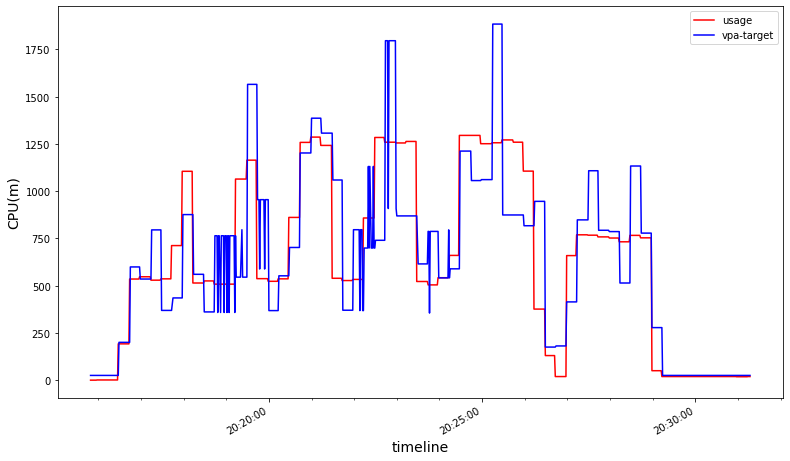

In [9]:
fig, ax = plt.subplots(1,1,figsize=(13,8),sharex=True,sharey=True)
# ax.scatter(request.time, request.cpu,marker='.',label='request')
ax.plot(usage.time, usage.cpu,label='usage',color='r')
ax.plot(vpa.time, vpa.target_cpu,label='vpa-target',color='b')
ax.legend()
ax.set_ylabel('CPU(m)', fontsize=14)
ax.set_xlabel('timeline', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
fig.autofmt_xdate() #rotate labels
plt.show()

In [10]:
def evaluate(usage, prediction):
    slack = list(map(operator.sub, prediction, usage))
    slack_total = 0
    insufficient_count = 0
    insufficient_total = 0
    for i in slack:
        if i < 0:
            insufficient_count += 1
            insufficient_total += abs(i)
        else:
            slack_total += i
    return slack_total/len(usage), insufficient_count/len(usage)*100, insufficient_total/len(usage)

In [11]:
sma = []
sma = evaluate(usage.cpu, vpa.target_cpu)
print("\tAvg. slack(m)\t Insufficient CPU(%)\t Avg. insufficient CPU(m)")
print("sma-5-3:", sma[0], sma[1], sma[2])

	Avg. slack(m)	 Insufficient CPU(%)	 Avg. insufficient CPU(m)
sma-5-3: 98.35777777777778 39.88888888888889 93.14666666666666
